In [1]:
%matplotlib inline

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. a real radiograph taken with a medical device
### Imaging a PMMA block
#### Authors: F. P. Vidal and Jenna Allsup

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to X-ray radiographs taken with a medical device. Medical devices often produce images in negative and image filtering, such as image sharpening, may alter their appearance. Another issue is the lack of flat-field correction to account for variations in the pixel-to-pixel sensitivity of the detector. 

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use a real radiograph of a plexiglass (PMMA) block. Its size is 32x27x4cm. The simulated geometry is registered using numerical optimisation so that its location and orientation match those of the real PMMA block. The source-to-object distance (SOD) and the source-to-detector distance (SDD) are also optimised. The initial estimation of the SDD is 130cm. The beam spectrum is polychromatic and the energy response of the detector is considered. The pixel-to-pixel sensitivity of the detector is corrected in the real radiograph. A plausible image sharpening filter is also integrated and optimised to mimich the appearance of a real image. Photon noise is also added to increase realism. The amount of noise is estimated for the real radiograph and optimised in the simulated image.

![Geometric parameters](doc/PMMA_setup.png)


**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the real radiograph and the simulated image without noise and with noise. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) and **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity)** are also used.

The ZNCC for the image without noise is 98.55%, and with noise 98.52%. Both values are extremely close to 100%. The SSIM for the image without noise is 0.93, and with noise 0.90. Both values are extremely close to 1.0. These results show that the simulated image is similar to the real X-ray radiograph acquired with a medical device. MAPE is, however, 27.06% for the image without noise, and 27.33% with noise. The difference between the real X-ray radiograph and the simulated image is due to the sharpening filter (we do not actually know how the manufacturer implemented it) and the pixel-to-pixel sensitivity of the detector (even after correction the horizontal profile in the middle of the real X-ray radiograph is not flat).

## Import Python packages

- Pretty common stuff: re, sys, os, math, copy, numpy
- cma for optimisation (minimisation of an objective function)
- gvxrPython3 to simulate X-ray images
- imageio to generate a GIF file
- matplotlib to plot graphs and display images
- scikit-image for comparing images and for implementing the image sharpening filter
- scikit-learn for computing the image comparison
- scipy for resampling the beam spectrum
- SimpleITK to load the medical DICOM file
- spekpy to generate a beam spectrum
- tifffile to load and save TIFF images in Float32

In [2]:
import re, sys, os, math, copy


import numpy as np # Who does not use Numpy?

import cma # Optimisation (minimisation of an objective function)
import gvxrPython3 as gvxr # Simulate X-ray images
import imageio # Generate a GIF file
import matplotlib # Plot graphs and display images
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from skimage.util import compare_images # Comparing images 
from skimage.filters import gaussian # Implementing the image sharpening filter
from skimage.metrics import structural_similarity as ssim # Quantifying the similarities between the simulated image and the ground truth
from sklearn.metrics import mean_squared_error # For the objective function
from sklearn.metrics import mean_absolute_percentage_error as mape # Quantifying the difference between the simulated image and the ground truth
from scipy import signal # Resampling the beam spectrum
import SimpleITK as sitk # Load the medical DICOM file
import spekpy as sp # Generate a beam spectrum
from tifffile import imsave, imread # Load and save TIFF images in Float32

## Read the real X-ray radiograph from a DICOM file

In [3]:
reader = sitk.ImageFileReader()
reader.SetImageIO("GDCMImageIO")
reader.SetFileName("PMMA_data/DX000000")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()    
volume = reader.Execute()
real_image = sitk.GetArrayFromImage(volume)[0]

In [4]:
# meta_data_keys = volume.GetMetaDataKeys()

# print("DICOM fields:")
# for key in meta_data_keys:
#     print(key, volume.GetMetaData(key))

In [5]:
# def cleanTags(raw_string):
#     regular_expression = re.compile('<.*?>')
#     clean_text = re.sub(regular_expression, '', raw_string)
#     return clean_text

In [6]:
# field = volume.GetMetaData("0033|1022")

# for item in field.split("\n"):
#     if "KV" in item:
#         kv = float(cleanTags(item))
        

# print(kv)

## Extract the image size and pixel spacing from the DICOM file

It will be useful to set the X-ray detector parameters for the simulation, and to display the images in millimetres.

In [7]:
spacing = volume.GetSpacing()[0:2]
size = volume.GetSize()[0:2]

# Extract the kVp from the DICOM file

It will be useful to generate a realistic beam spectrum.

In [8]:
kVp = float(volume.GetMetaData("0018|0060"))
print("Peak kilo voltage output of the x-ray generator used: ", kVp)

Peak kilo voltage output of the x-ray generator used:  89.9


## Display the experimental radiograph from the DICOM file

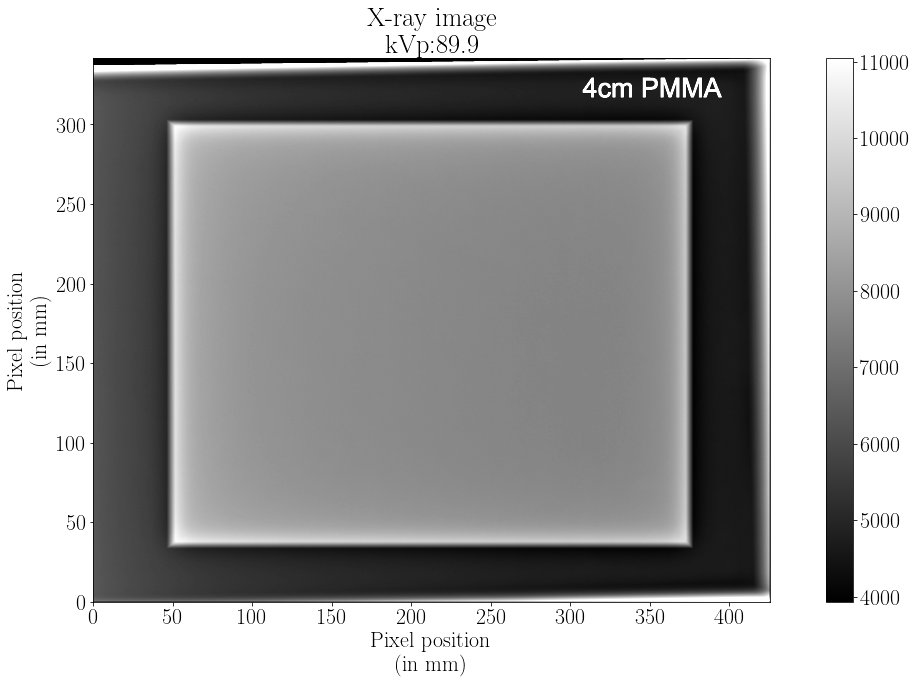

In [9]:
plt.figure(figsize= (20,10))
xrange=range(real_image.shape[1])
yrange=range(real_image.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(real_image, cmap="gray", 
           vmin=3934, vmax = 11045,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

plt.savefig('plots/PMMA_experimental_image.pdf')
plt.savefig('plots/PMMA_experimental_image.png')

We can see on the picture that the pixel-to-pixel sensitivity of the detector varries. Pixels on the left-hand side of the image are brighter than on the right-hand side. 

# Flat-field correction

We are going to correct the pixel-to-pixel sensitivity of the detector and implement a mock flat-field correction. We extract two lines from the image where there is no object. The two lines are stored in two 1D arrays. We create a new array as the element-wise average of the two arrays. Every line of the image is then corrected with an element-wise division.

In [10]:
line1 = real_image[222,:] # A line of the image with no object
line2 = real_image[2283,:] # Another line of the image with no object
line = 0.5 * line1 + 0.5 * line2 # Element-wise average of the two arrays
line[line.shape[0]-1] = 1 # Make sure the last element is not zero (to avoid a division by zero)

# Create the full-field image
full_field = np.zeros(real_image.shape)

for i in range(real_image.shape[1]):
    full_field[:,i] = line[i]

# Apply the correction
real_image = real_image / full_field

# Save the corrected image
imsave("gVirtualXRay_output_data/PMMA_block_real_image_flat.tif", real_image.astype(np.single))

Display the image after correction

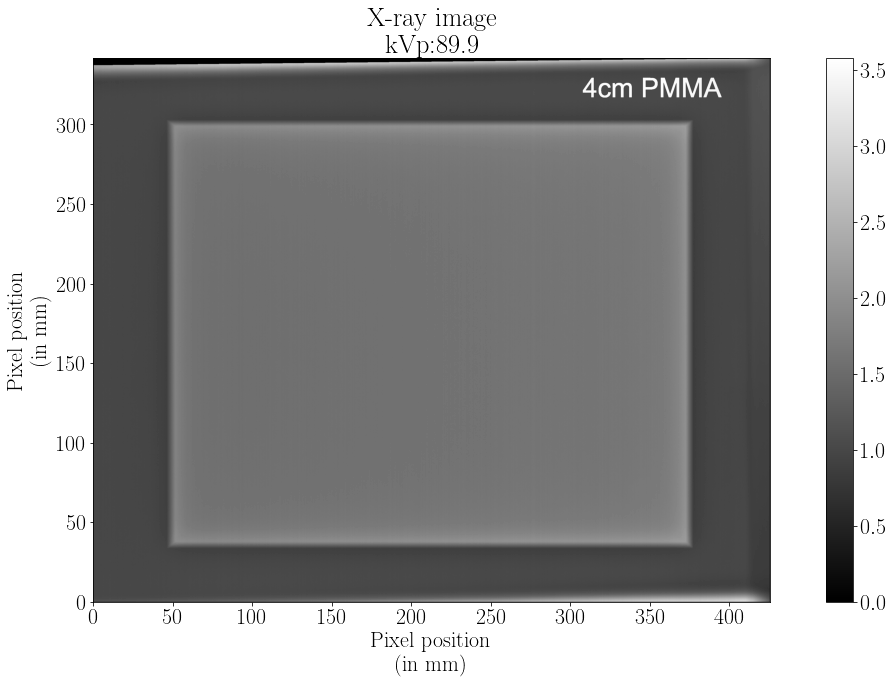

In [11]:
plt.figure(figsize= (20,10))
xrange=range(real_image.shape[1])
yrange=range(real_image.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(real_image, cmap="gray", 
           # vmin=-1, vmax = 1,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

plt.savefig('plots/PMMA_experimental_image_flat.pdf')
plt.savefig('plots/PMMA_experimental_image_flat.png')

## Crop it to remove the text

There are parts of the image that need to be removed, e.g. the text.

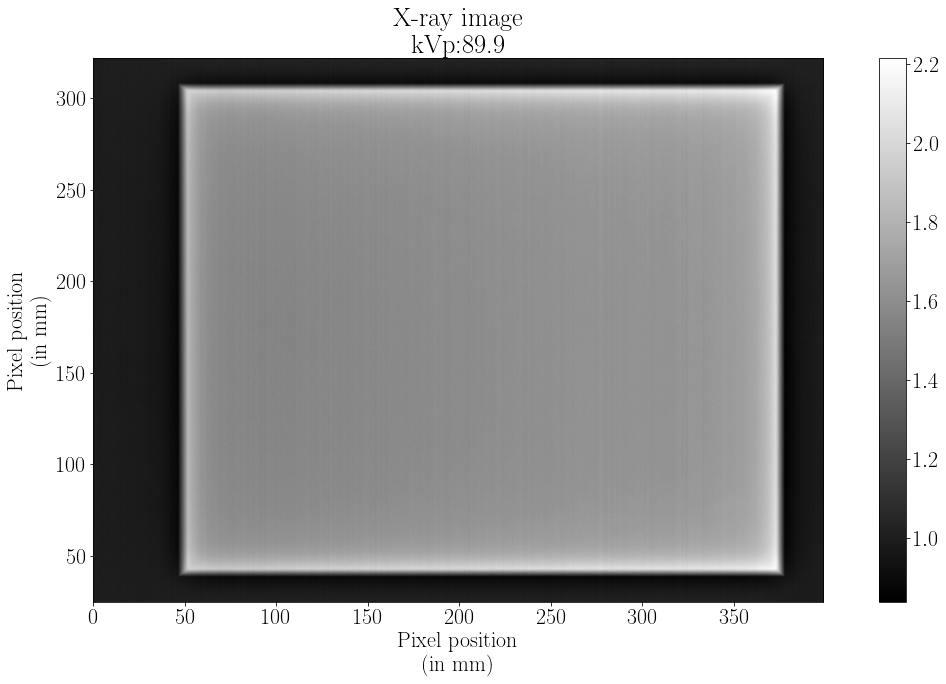

In [12]:
plt.figure(figsize= (20,10))

roi = [179, 2300, 0, 2848]
roi_real_image = real_image[179:2300,0:2848]

xrange=range(roi_real_image.shape[1])
yrange=range(roi_real_image.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(roi_real_image, cmap="gray", 
           extent=[roi[2] * spacing[0], (roi[3] -1) *spacing[0], roi[0]*spacing[0],(roi[1] - 1)*spacing[0]])
plt.colorbar(orientation='vertical')

plt.savefig('plots/PMMA_experimental_image-cropped.pdf')
plt.savefig('plots/PMMA_experimental_image-cropped.png')

## Set the experimental parameters (e.g. source and detector positions, etc.)

We use known parameters as much as possible, for example we know the size and composition of the sample. Some parameters are extracted from the DICOM file, such as detector size, pixel resolution, and voltage of the X-ray tube.

In [13]:
source_detector_distance_in_cm = 130  # See email Mon 05/07/2021 15:29
block_width_in_cm = 32
block_height_in_cm = 27
block_thickness_in_cm = 4

window_size =  [800, 450]
source_position = [0.0, 0.0, source_detector_distance_in_cm - block_thickness_in_cm / 2, "cm"]
detector_position = [0.0, 0.0, - block_thickness_in_cm / 2, "cm"]
detector_up = [0, 1, 0]

## Initialise the simulation engine

In [14]:
# Create an OpenGL context
print("Create an OpenGL context:",
    str(window_size[0]) + "x" + str(window_size[1])
);
gvxr.createOpenGLContext();
gvxr.setWindowSize(
    window_size[0],
    window_size[1]
);


Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## Function to create a PMMA block

In [15]:
def createBlock(x, y, z, r, h):
    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph()

    # Make a cube
    gvxr.makeCube("PMMA block", 1.0, "mm")

    # Translation vector
    gvxr.translateNode("PMMA block", x, y, z, "cm")

    # Rotation angle
    gvxr.rotateNode("PMMA block", r, 0, 0, 1)

    # Scaling factors
    gvxr.scaleNode("PMMA block", block_width_in_cm * 10, h * 10, block_thickness_in_cm * 10);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("PMMA block");

    # Set the matrix's material properties
    gvxr.setCompound("PMMA block", "C5O2H8")
    gvxr.setDensity("PMMA block", 1.18, "g/cm3")

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("PMMA block")

In [16]:
# Initial guess
x = y = 0
z = 0
r = 0
createBlock(x, y, z, r, block_height_in_cm)

## Set the source position

In [17]:
# Set up the beam
print("Set up the beam")
print("\tSource position:", source_position)
gvxr.setSourcePosition(
    source_position[0],
    source_position[1],
    source_position[2],
    source_position[3]
);

gvxr.usePointSource();

focal_spot_size = volume.GetMetaData("0018|1413")
# gvxr.setFocalSpot(focal_spot_size, focal_spot_size, focal_spot_size, "mm");
print("size of focal spot (in mm):", focal_spot_size)

Set up the beam
	Source position: [0.0, 0.0, 128.0, 'cm']
size of focal spot (in mm): 11.653


# Get the spectrum from the DICOM file

In [18]:
spectrum = {};
filter_material = "Al"      # See email Mon 05/07/2021 15:29
filter_thickness_in_mm = 3  # See email Mon 05/07/2021 15:29

s = sp.Spek(kvp=kVp)
s.filter(filter_material, filter_thickness_in_mm) # Filter by 3 mm of Al
unit = "keV"
k, f = s.get_spectrum(edges=True) # Get the spectrum

min_energy = sys.float_info.max
max_energy = -sys.float_info.max

for energy, count in zip(k, f):
    count = round(count)

    if count > 0:

        max_energy = max(max_energy, energy)
        min_energy = min(min_energy, energy)

        if energy in spectrum.keys():
            spectrum[energy] += count
        else:
            spectrum[energy] = count

Reformat the data

In [19]:
# get the integral nb of photons
nbphotons=0.
energy1 = -1.
energy2 = -1.

for energy in spectrum.keys():
    
    if energy1<0:
        energy1 = float(energy)
    elif energy2<0:
        energy2 = float(energy)
    nbphotons += float(spectrum[energy])
sampling = (energy2-energy1)

# get spectrum
data = []
for energy in spectrum.keys():
    source = [float(energy),float(spectrum[energy])/(nbphotons*sampling)]
    data.append(source)

data_array = np.array(data)

energies, counts = data_array.T


Resample the data to reduce the number of bins

In [20]:
number_of_energy_bins = 30
count_set = signal.resample(counts, number_of_energy_bins)
energy_set = np.linspace(energies.min(), energies.max(), number_of_energy_bins, endpoint=True)

Plot the beam spectrum from spekpy and the resampled vervion

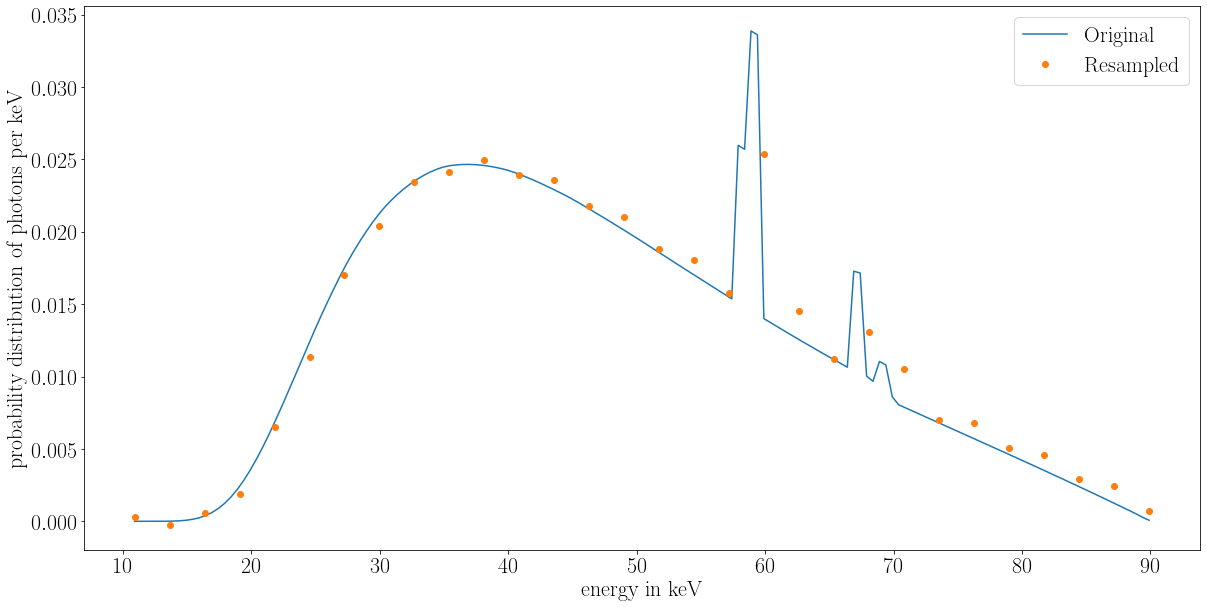

In [21]:
plt.figure(figsize= (20,10))
plt.plot(energies, counts, label="Original")
plt.plot(energy_set, count_set, "o", label="Resampled")
plt.xlabel('energy in keV')
plt.ylabel('probability distribution of photons per keV')
plt.legend()
plt.savefig("plots/spectrum.pdf")

## Load the beam spectrum in the simulator

In [22]:
gvxr.resetBeamSpectrum() # To be on the safe side when debugging
for energy, count in zip(energy_set, count_set):
    gvxr.addEnergyBinToSpectrum(energy, unit, count);

## Set the X-ray detector

In [23]:
# Set up the detector
print("Set up the detector");
print("\tDetector position:", detector_position)
gvxr.setDetectorPosition(
    detector_position[0],
    detector_position[1],
    detector_position[2],
    detector_position[3]
);

print("\tDetector up vector:", detector_up)
gvxr.setDetectorUpVector(
    detector_up[0],
    detector_up[1],
    detector_up[2]
);

Set up the detector
	Detector position: [0.0, 0.0, -2.0, 'cm']
	Detector up vector: [0, 1, 0]


In [24]:
print("\tDetector number of pixels:", size)
gvxr.setDetectorNumberOfPixels(
    size[0],
    size[1]
);

print("\tPixel spacing:", spacing)
gvxr.setDetectorPixelSize(
    spacing[0],
    spacing[1],
    "mm"
);

	Detector number of pixels: (3040, 2442)
	Pixel spacing: (0.14, 0.14)
INIT RENDER


Load the detector response in energy

In [25]:
gvxr.clearDetectorEnergyResponse() # To be on the safe side
gvxr.loadDetectorEnergyResponse("Gate_data/responseDetector.txt",
                                "MeV")


## Take a screenshot of the 3D environment

In [26]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setSceneRotationMatrix([0.43813619017601013, 0.09238918125629425, -0.8941444158554077, 0.0,
                             0.06627026945352554, 0.9886708855628967, 0.13463231921195984, 0.0,
                             0.8964602947235107, -0.11824299395084381, 0.4270564019680023, 0.0,
                             0.0, 0.0, 0.0, 1.0])
gvxr.setZoom(1639.6787109375)

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [27]:
screenshot = gvxr.takeScreenshot()

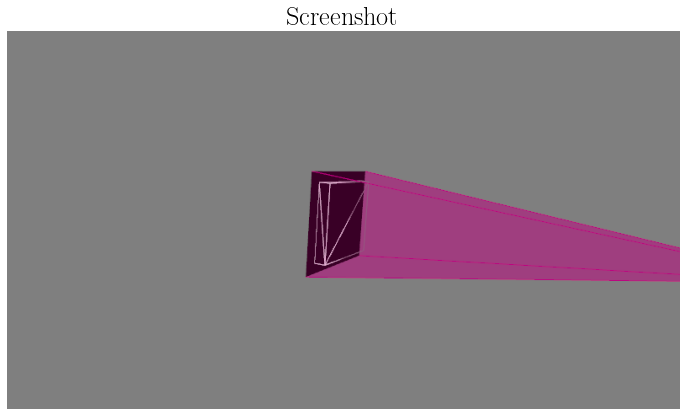

In [28]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/PMMA_screenshot-beam-off.pdf')
plt.savefig('plots/PMMA_screenshot-beam-off.png')

# Optimise the position and orientation of the PMMA block, and refine the SDD

In [29]:
def standardisation(image):
    return (image - image.mean()) / image.std();

In [30]:
def zncc(i1, i2):
    return (np.mean(np.multiply(i1, i2))) / 2.0;

In [31]:
def objectiveFunction(parameters):
    
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global evolution_zncc
    global evolution_parameters
    
    # Retrieve the parameters
    x, y, z, r, h, SDD = parameters
    
    # Update the source position
    source_position = [0.0, 0.0, SDD - block_thickness_in_cm / 2, "cm"]
    gvxr.setSourcePosition(
        source_position[0],
        source_position[1],
        source_position[2],
        source_position[3]
    );

    # Update the block geometry
    createBlock(x, y, z, r, h)
    
    # Compute an X-ray image
    x_ray_image = np.array(gvxr.computeXRayImage())
    
    # Compute the negative image as it is the case for the real image
    x_ray_image *= -1.
    
    # Crop the image
    x_ray_image = x_ray_image[179:2300,0:2848]

    # Zero-mean, unit-variance normalistion
    x_ray_image = standardisation(x_ray_image)
    
    # Return the objective
    objective = math.sqrt(mean_squared_error(roi_real_image, x_ray_image))

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        
        gvxr.displayScene()
        screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

        # gvxr.saveSTLfile("PMMA block", "gVirtualXRay_output_data/PMMA_block_" + str(best_fitness_id) + ".stl")
        # np.savetxt("gVirtualXRay_output_data/PMMA_block_" + str(best_fitness_id) + ".dat", [x, y, z, r, h, SDD], header='x,y,z,r,h,SDD')
        imsave("gVirtualXRay_output_data/PMMA_block_xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
        imsave("gVirtualXRay_output_data/PMMA_block_screenshot_" + str(best_fitness_id) + ".tif", screenshot)
    
        zncc_value = zncc(roi_real_image, x_ray_image)
        evolution_zncc.append([fitness_function_call_id, zncc_value])
        evolution_parameters.append([fitness_function_call_id, x, y, z, r, h, SDD])
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
    
    return objective

In [32]:
# Zero-mean, unit-variance normalistion
roi_real_image = standardisation(roi_real_image)
imsave("gVirtualXRay_output_data/PMMA_block_roi_real_image.tif", roi_real_image)

In [33]:
# The registration has already been performed. Load the results.
if os.path.isfile("gVirtualXRay_output_data/PMMA_block.dat") and \
        os.path.isfile("gVirtualXRay_output_data/PMMA_block_evolution_zncc.dat") and \
        os.path.isfile("gVirtualXRay_output_data/PMMA_block_evolution_parameters.dat"):
    
    temp = np.loadtxt("gVirtualXRay_output_data/PMMA_block.dat")
    x = temp[0]
    y = temp[1]
    z = temp[2]
    r = temp[3]
    block_height_in_cm = temp[4]
    source_detector_distance_in_cm = temp[5]
    
    # Update the source position
    source_position = [0.0, 0.0, source_detector_distance_in_cm - block_thickness_in_cm / 2, "cm"]
    gvxr.setSourcePosition(
        source_position[0],
        source_position[1],
        source_position[2],
        source_position[3]
    );
    
    # Update the block geometry
    createBlock(x, y, z, r, block_height_in_cm)

    evolution_zncc = np.loadtxt("gVirtualXRay_output_data/PMMA_block_evolution_zncc.dat")
    evolution_parameters = np.loadtxt("gVirtualXRay_output_data/PMMA_block_evolution_parameters.dat")

else:
    # Optimise
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2)
    opts['tolx'] = 1e-2
    opts['bounds'] = [[-20, -20, detector_position[2] + block_thickness_in_cm / 2, -90, block_height_in_cm * 0.80, source_detector_distance_in_cm * 0.80],
                      [20, 20, source_position[2] - block_thickness_in_cm / 2, 90, block_height_in_cm * 1.20, source_detector_distance_in_cm * 1.20]]
    opts['CMA_stds'] = []

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    fitness_function_call_id = 0
    evolution_zncc = []
    evolution_parameters = []
        
    # Optimise
    res = cma.fmin(objectiveFunction,
              [x, y, z, r, block_height_in_cm, source_detector_distance_in_cm],
              0.5,
              opts,
              restarts=1) 
    x, y, z, r, block_height_in_cm, source_detector_distance_in_cm = res[0]
    
    # Save the parameters
    np.savetxt("gVirtualXRay_output_data/PMMA_block.dat", [x, y, z, r, block_height_in_cm, source_detector_distance_in_cm], header='x,y,z,r,h,SDD')

    # Update the source position
    source_position = [0.0, 0.0, source_detector_distance_in_cm - block_thickness_in_cm / 2, "cm"]
    gvxr.setSourcePosition(
        source_position[0],
        source_position[1],
        source_position[2],
        source_position[3]
    );
    
    # Update the block geometry
    createBlock(x, y, z, r, block_height_in_cm)
    gvxr.saveSTLfile("PMMA block", "CAD_models/PMMA_block.stl")

    evolution_zncc = np.array(evolution_zncc)
    np.savetxt("gVirtualXRay_output_data/PMMA_block_evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

    evolution_parameters = np.array(evolution_parameters)
    np.savetxt("gVirtualXRay_output_data/PMMA_block_evolution_parameters.dat", evolution_parameters, header='t,x,y,z,r,h,SDD')

In [34]:
print("SDD (in cm):", source_detector_distance_in_cm)
print("Block centre (in cm):", x, y, z)
print("Block size (in cm):", block_width_in_cm, block_height_in_cm, block_thickness_in_cm)
print("Rotation angle (in degrees):", r)

SDD (in cm): 135.527653265263
Block centre (in cm): -0.06603673349624295 0.24004377695826978 0.4526023680030148
Block size (in cm): 32 26.076640918215908 4
Rotation angle (in degrees): -0.0020670995385289256


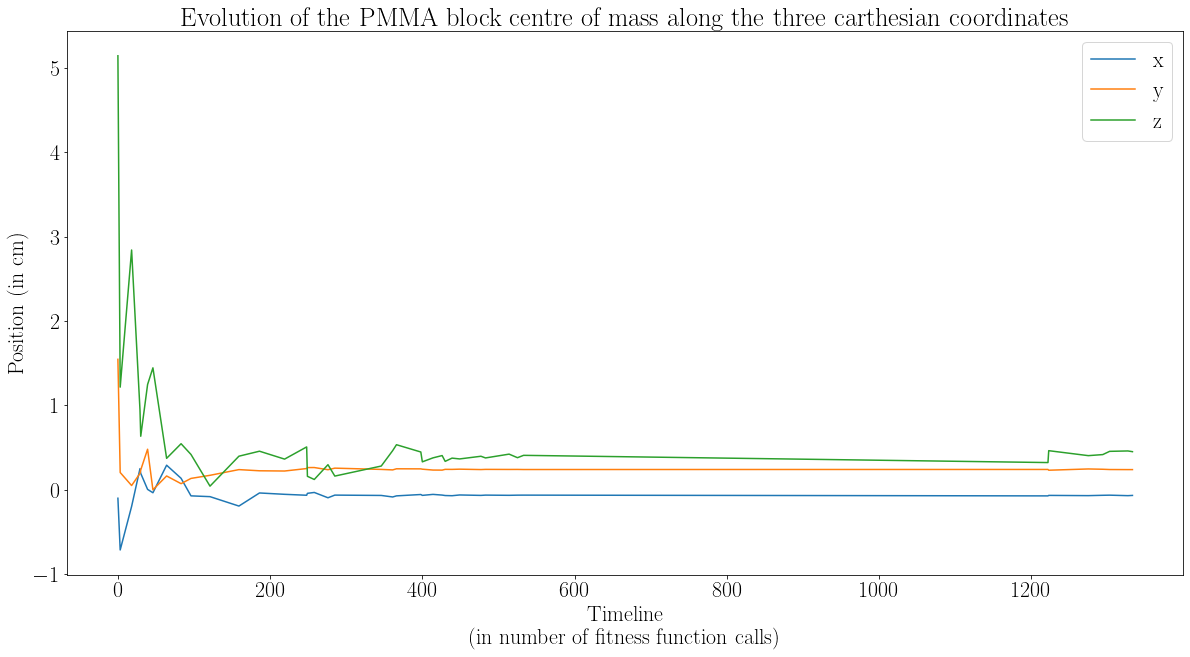

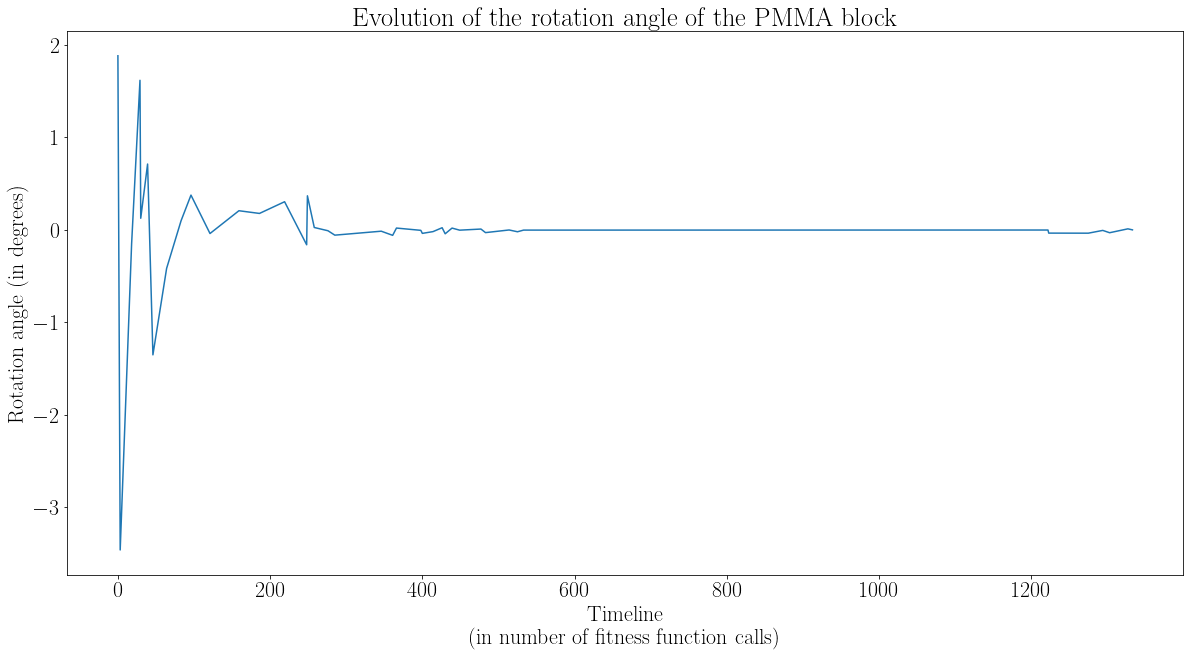

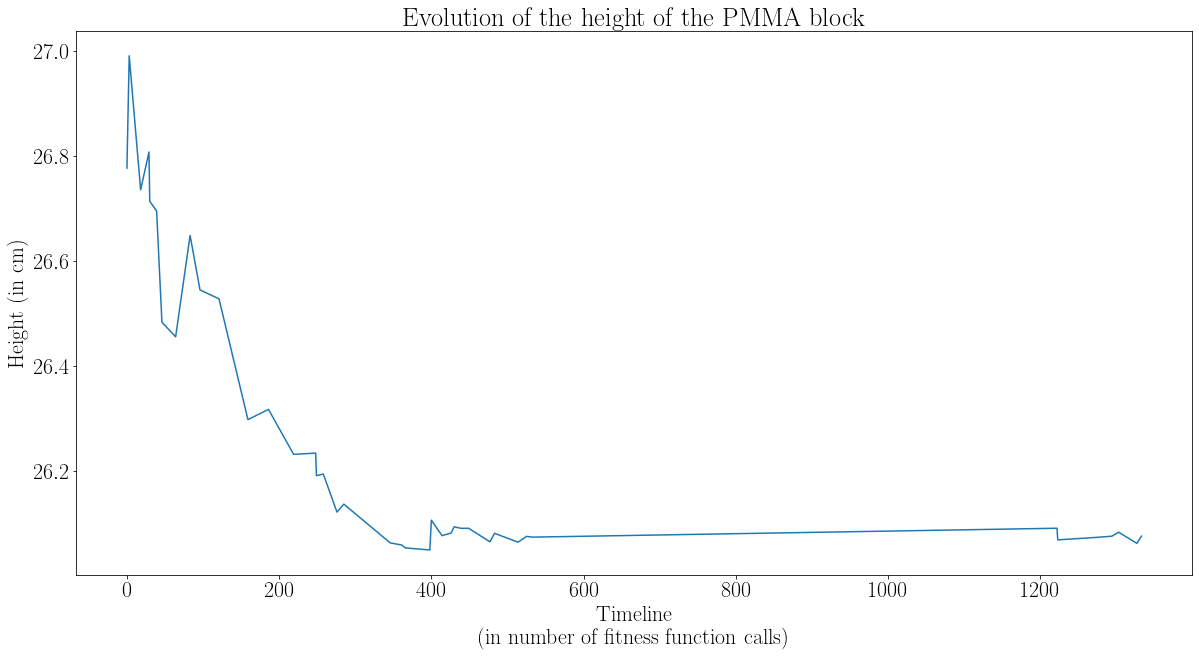

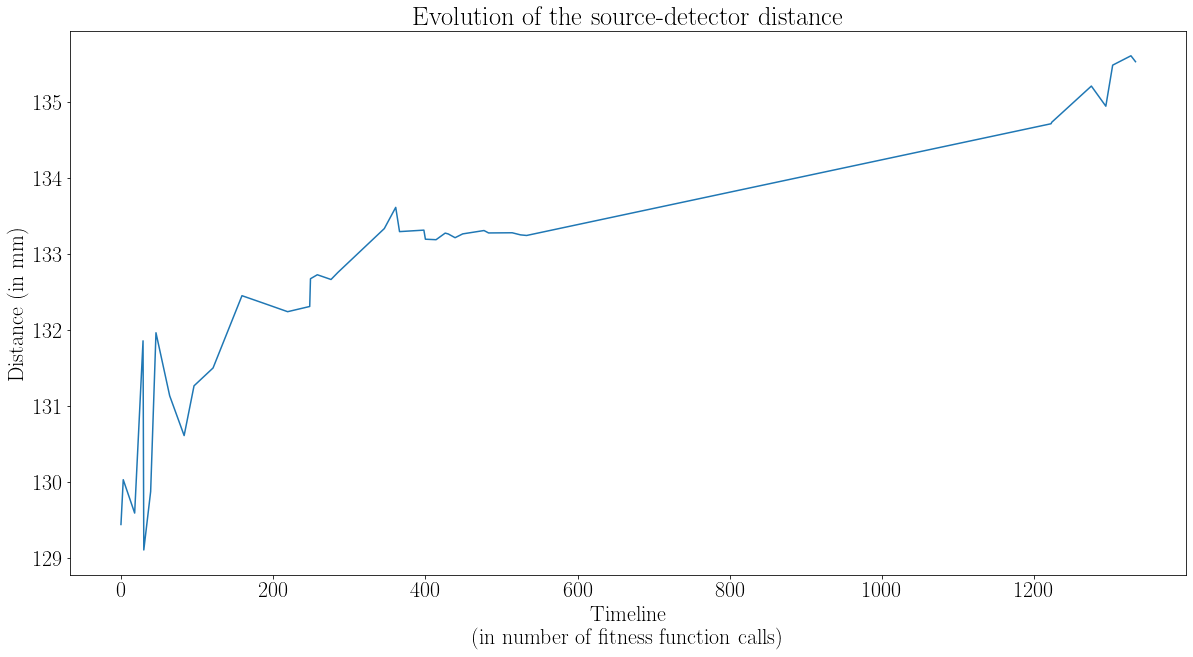

In [35]:
evolution_parameters = np.array(evolution_parameters)

plt.figure(figsize= (20,10))
plt.title("Evolution of the PMMA block centre of mass along the three carthesian coordinates")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,1], label="x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,2], label="y")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,3], label="z")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Position (in cm)")
plt.legend()
plt.savefig('plots/PMMA_block_evolution_centre_of_mass.pdf')
plt.savefig('plots/PMMA_block_volution_centre_of_mass.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the rotation angle of the PMMA block")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,4], label="angle")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Rotation angle (in degrees)")
plt.savefig('plots/PMMA_block_evolution_centre_of_mass.pdf')
plt.savefig('plots/PMMA_block_evolution_centre_of_mass.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the height of the PMMA block")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,5], label="angle")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Height (in cm)")
plt.savefig('plots/PMMA_block_evolution_height.pdf')
plt.savefig('plots/PMMA_block_evolution_height.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-detector distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,6])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in mm)")
plt.savefig('plots/PMMA_block_evolution_SDD.pdf')
plt.savefig('plots/PMMA_block_evolution_SDD.png')

In [36]:
# Compute an X-ray image
raw_x_ray_image = np.array(gvxr.computeXRayImage())

gvxr.displayScene()

# Compute the negative image as it is the case for the real image
x_ray_image = raw_x_ray_image * -1.

# Crop the image
x_ray_image = x_ray_image[179:2300,0:2848]

# Zero-mean, unit-variance normalistion
x_ray_image = standardisation(x_ray_image)

## Plot the evolution of the quality of the simulated image

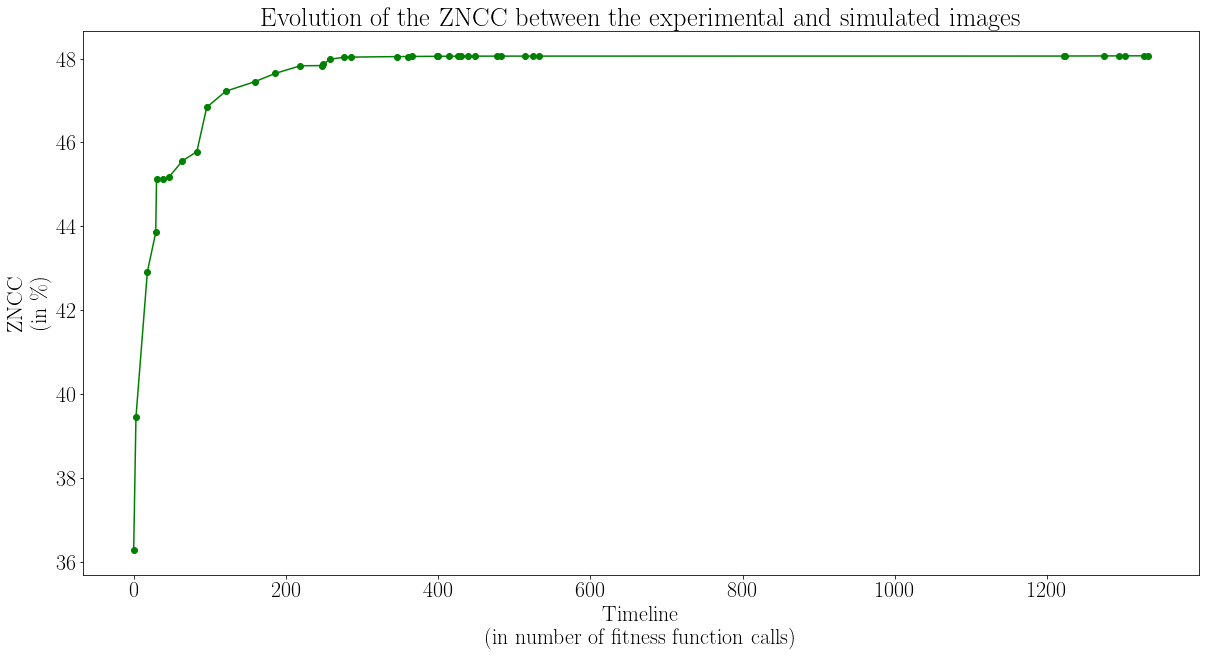

In [37]:
plt.figure(figsize= (20,10))
plt.title("Evolution of the ZNCC between the experimental and simulated images")
plt.plot(evolution_zncc[:,0], 100.0 * evolution_zncc[:,1], "go-")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("ZNCC\n(in \%)")
plt.savefig('plots/PMMA_block_evolution_ZNCC1.pdf')
plt.savefig('plots/PMMA_block_evolution_ZNCC1.png')

In [38]:
def compareImages(real_image, x_ray_image, colorbar=True, rows = 1, cols = 3):
    comp_equalized = compare_images(real_image, x_ray_image, method='checkerboard');
    
#     plt.figure(figsize= (20,10))

    # plt.suptitle("Image simulated using gVirtualXRay without the energy response of the detector", y=1.02)

    plt.subplot(rows, cols, 1)
    plt.imshow(real_image, cmap="gray", vmin=-1, vmax=1,
               extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
    if colorbar:
        plt.colorbar(orientation='horizontal')
    plt.title("Experimental image")
    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Pixel position\n(in mm)")

    plt.subplot(rows, cols, 2)
    plt.imshow(x_ray_image, cmap="gray", vmin=-1, vmax=1,
               extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
    if colorbar:
        plt.colorbar(orientation='horizontal')
    plt.title("Simulated image")
    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Pixel position\n(in mm)")

    plt.subplot(rows, cols, 3)
    plt.imshow(comp_equalized, cmap="gray", vmin=-1, vmax=1,
               extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
    if colorbar:
        plt.colorbar(orientation='horizontal')
    plt.title("Checkerboard comparison")
    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Pixel position\n(in mm)")

    plt.tight_layout()

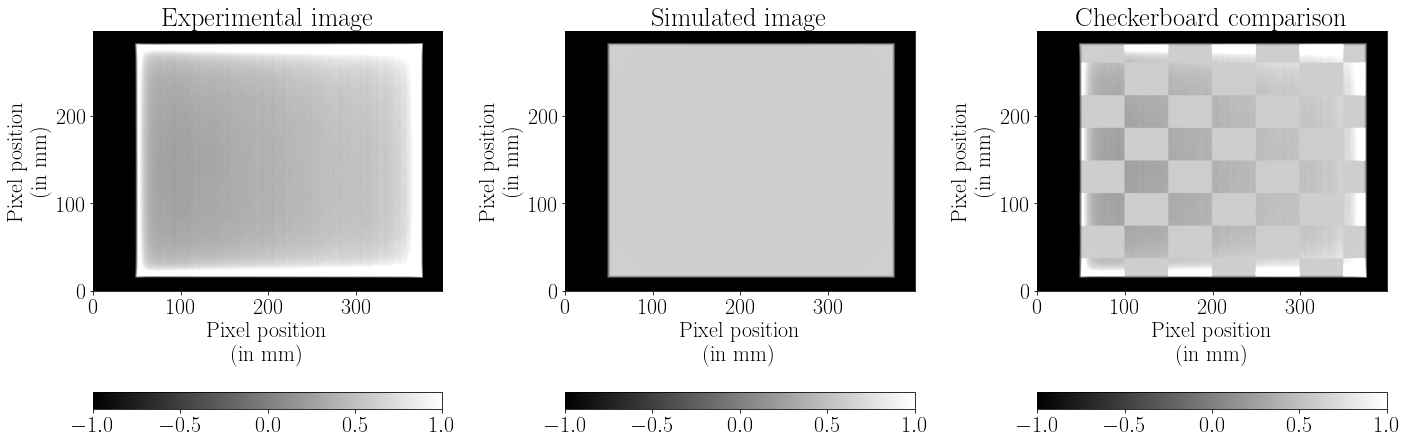

In [39]:
plt.figure(figsize= (20,10))
compareImages(roi_real_image, x_ray_image)
plt.savefig('plots/PMMA_block_compare_images1.pdf')
plt.savefig('plots/PMMA_block_compare_images1.png')

In [40]:
def drawHorizontalProfiles(real_image, x_ray_image, x_ray_image_noise=None):

    horizontal_profile_real_image = real_image[real_image.shape[1] // 2]
    horizontal_profile_simulated_image = x_ray_image[x_ray_image.shape[1] // 2]

    x_val = np.linspace(0.0,
                        spacing[0] * real_image.shape[1],
                        real_image.shape[1], endpoint=True)

    plt.plot(x_val, horizontal_profile_real_image, label="Experimental image")
    
    if x_ray_image_noise is not None:
        horizontal_profile_simulated_image_noise = x_ray_image_noise[x_ray_image_noise.shape[1] // 2]
        plt.plot(x_val, horizontal_profile_simulated_image_noise, label="Simulated image with noise")

    plt.plot(x_val, horizontal_profile_simulated_image, label="Simulated image without noise")

    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Relative intensity")

In [41]:
def drawVerticalProfiles(real_image, x_ray_image, x_ray_image_noise=None):
    vertical_profile_real_image = real_image[:,real_image.shape[0] // 2]
    vertical_profile_simulated_image = x_ray_image[:,x_ray_image.shape[0] // 2]

    x_val = np.linspace(0.0,
                        spacing[1] * real_image.shape[0],
                        real_image.shape[0], endpoint=True)

    plt.plot(x_val, vertical_profile_real_image, label="Experimental image")
    
    if x_ray_image_noise is not None:
        vertical_profile_simulated_image_noise = x_ray_image_noise[:,x_ray_image_noise.shape[0] // 2]
        plt.plot(x_val, vertical_profile_simulated_image_noise, label="Simulated image with noise")

    plt.plot(x_val, vertical_profile_simulated_image, label="Simulated image without noise")

    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Relative intensity")

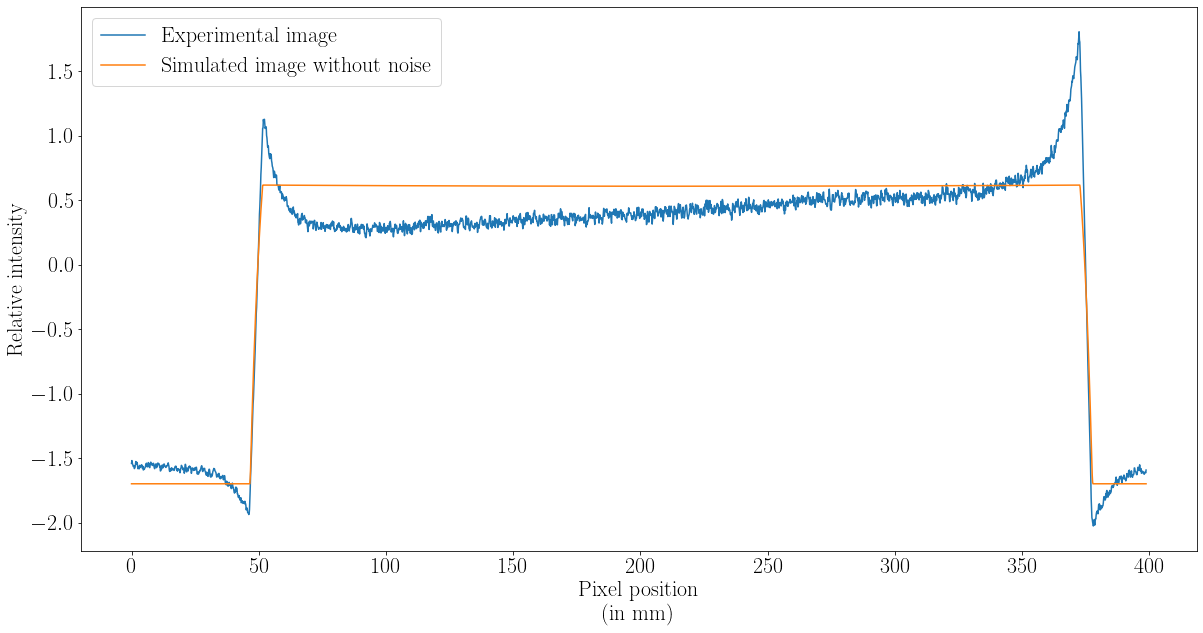

In [42]:
plt.figure(figsize= (20,10))
drawHorizontalProfiles(roi_real_image, x_ray_image)
plt.legend()
plt.savefig('plots/PMMA_block_compare_horizontal_profile1.pdf')
plt.savefig('plots/PMMA_block_compare_horizontal_profile1.png')

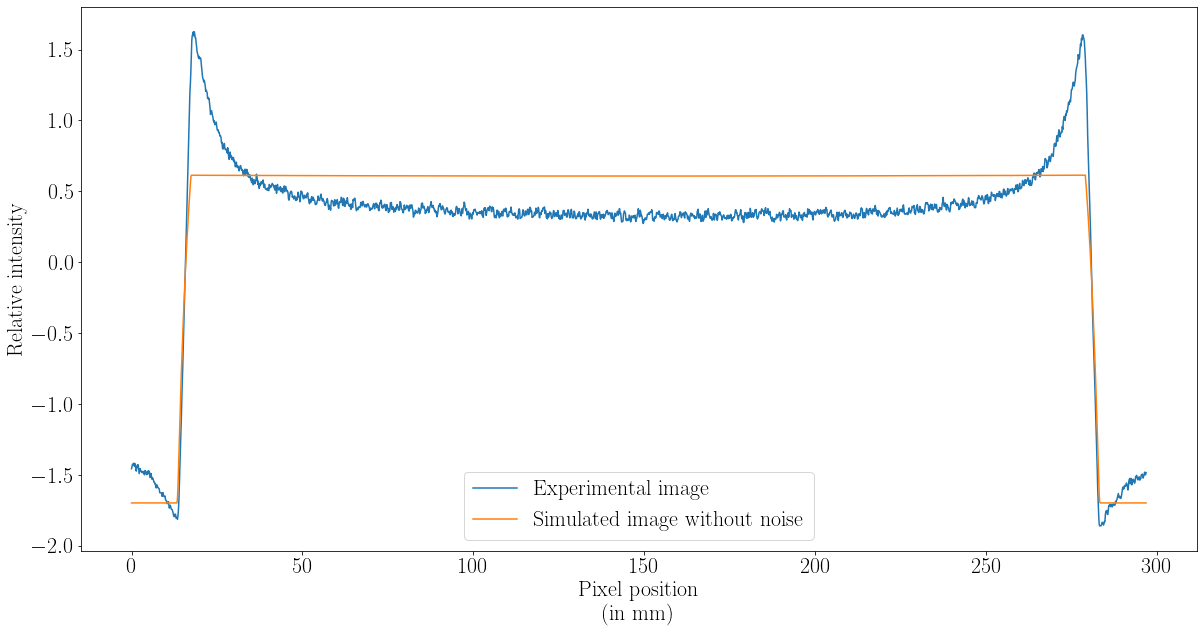

In [43]:
plt.figure(figsize= (20,10))
drawVerticalProfiles(roi_real_image, x_ray_image)
plt.legend()
plt.savefig('plots/PMMA_block_compare_vertical_profile1.pdf')
plt.savefig('plots/PMMA_block_compare_vertical_profile1.png')

In [44]:
def createAnimation(evolution_parameters, real_image):
    # Create the GIF file
    with imageio.get_writer("plots/PMMA_block_evolution.gif", mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i, [t, x, y, z, r, w, SDD] in enumerate(evolution_parameters):
            t = int(t)
            
            x_ray_image = imread("gVirtualXRay_output_data/PMMA_block_xray_" + str(i) + ".tif")
            screenshot = imread("gVirtualXRay_output_data/PMMA_block_screenshot_" + str(i) + ".tif")
            
            # Create the figure
            fig, axs = plt.subplots(nrows=2, ncols=3, figsize= (20,10))
            plt.suptitle("Iteration " + str(t+1) + "/" + str(int(evolution_parameters[-1][0]+1)))
            compareImages(real_image, x_ray_image, False, 2, 3)
      
            plt.subplot(234)
            drawHorizontalProfiles(real_image, x_ray_image)

            plt.subplot(235)
            drawVerticalProfiles(real_image, x_ray_image)
  

            plt.subplot(236)
            plt.imshow(screenshot)

            # Save the figure as a PNG file
            plt.savefig("temp.png")

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread("temp.png")
            writer.append_data(image)

            # Delete the PNG file
            os.remove("temp.png");

        for i in range(15):
            writer.append_data(image)

In [45]:
if not os.path.exists("plots/PMMA_block_evolution.gif"):
    createAnimation(evolution_parameters, roi_real_image)

![GIF animation of the artificial evolution results](./plots/PMMA_block_evolution.gif)

# Image sharpening

We can see from the real image that an image sharpening filter was applied. We will implement one and optimise its parameters.

In [46]:
def sharpen(image, ksize, alpha, shift, scale):
    details = image - gaussian(image, ksize)    

    return scale * (shift + image) + alpha * details

In [47]:
def objectiveFunctionSharpen(parameters):
    
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global sharpened_evolution_zncc
    global sharpened_evolution_parameters

    global raw_x_ray_image
    
    # Retrieve the parameters
    sigma, alpha, shift, scale = parameters
    
    # Compute an X-ray image
    x_ray_image = sharpen(raw_x_ray_image, sigma, alpha, shift, scale)
    
    # Compute the negative image as it is the case for the real image
    x_ray_image *= -1.
    
    # Crop the image
    x_ray_image = x_ray_image[179:2300,0:2848]

    # Zero-mean, unit-variance normalistion
    x_ray_image = standardisation(x_ray_image)
    
    # Return the objective
    objective = math.sqrt(mean_squared_error(roi_real_image, x_ray_image))

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        
        imsave("gVirtualXRay_output_data/PMMA_block_sharpened_xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
    
        zncc_value = zncc(roi_real_image, x_ray_image)
        sharpened_evolution_zncc.append([fitness_function_call_id, zncc_value])
        sharpened_evolution_parameters.append([fitness_function_call_id, sigma, alpha, shift, scale])
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
    
    return objective

In [48]:
old_zncc = evolution_zncc[-1][1]

In [49]:
# The registration has already been performed. Load the results.
if os.path.isfile("gVirtualXRay_output_data/PMMA_block_sharpen.dat") and \
        os.path.isfile("gVirtualXRay_output_data/PMMA_block_sharpen_evolution_zncc.dat") and \
        os.path.isfile("gVirtualXRay_output_data/PMMA_block_sharpen_evolution_parameters.dat"):

    temp = np.loadtxt("gVirtualXRay_output_data/PMMA_block_sharpen.dat")
    sigma = temp[0]
    alpha = temp[1]
    shift = temp[2]
    scale = temp[3]
    
    sharpened_evolution_zncc = np.loadtxt("gVirtualXRay_output_data/PMMA_block_sharpen_evolution_zncc.dat")
    sharpened_evolution_parameters = np.loadtxt("gVirtualXRay_output_data/PMMA_block_sharpen_evolution_parameters.dat")

else:
    # Optimise
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3)
    opts['tolx'] = 1e-3
    opts['bounds'] = [[3, 0, -5, 0],
                      [200, 15, 5, 2]]
    opts['CMA_stds'] = []

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    fitness_function_call_id = 0
    sharpened_evolution_zncc = []
    sharpened_evolution_parameters = []
    
    sigma = 100
    alpha = 2.5
    shift = 0
    scale = 1
    
    # Optimise
    es = cma.CMAEvolutionStrategy([sigma, alpha, shift, scale], 0.5, opts)
    es.optimize(objectiveFunctionSharpen)

    # Save the parameters
    sigma, alpha, shift, scale = es.result.xbest
    np.savetxt("gVirtualXRay_output_data/PMMA_block_sharpen.dat", [sigma, alpha, shift, scale], header='sigma,alpha,shift,scale')

    sharpened_evolution_zncc = np.array(sharpened_evolution_zncc)
    np.savetxt("gVirtualXRay_output_data/PMMA_block_sharpen_evolution_zncc.dat", sharpened_evolution_zncc, header='t,ZNCC')

    sharpened_evolution_parameters = np.array(sharpened_evolution_parameters)
    np.savetxt("gVirtualXRay_output_data/PMMA_block_sharpen_evolution_parameters.dat", sharpened_evolution_parameters, header='t,sigma,alpha')

    # Release memory
    del es;

In [50]:
new_zncc = sharpened_evolution_zncc[-1][1]

In [51]:
print("ZNCC before sharpening:", str(100 * old_zncc) + "%")
print("ZNCC after sharpening:", str(100 * new_zncc) + "%")

ZNCC before sharpening: 48.06608053384178%
ZNCC after sharpening: 49.27706427803837%


In [52]:
print(evolution_zncc[-1,0])

1333.0


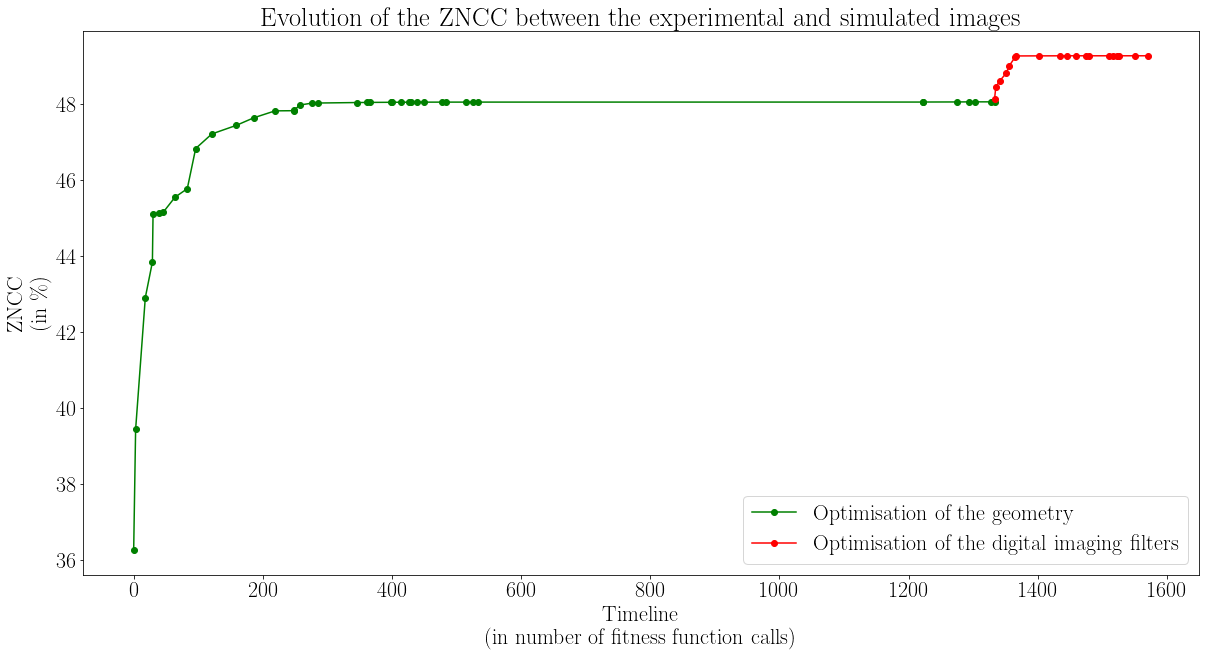

In [53]:
plt.figure(figsize= (20,10))
plt.title("Evolution of the ZNCC between the experimental and simulated images")
plt.plot(evolution_zncc[:,0], 100 * evolution_zncc[:,1], "go-", label="Optimisation of the geometry")
plt.plot(sharpened_evolution_zncc[:,0] + evolution_zncc[-1,0], 100 * sharpened_evolution_zncc[:,1], "ro-", label="Optimisation of the digital imaging filters")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("ZNCC\n(in \%)")
plt.legend()
plt.savefig('plots/PMMA_block_evolution_ZNCC2.pdf')
plt.savefig('plots/PMMA_block_evolution_ZNCC2.png')

In [54]:
# Compute an X-ray image
x_ray_image = sharpen(raw_x_ray_image, sigma, alpha, shift, scale)

# Compute the negative image as it is the case for the real image
x_ray_image *= -1.

# Crop the image
x_ray_image = x_ray_image[179:2300,0:2848]

# Zero-mean, unit-variance normalistion
x_ray_image = standardisation(x_ray_image)

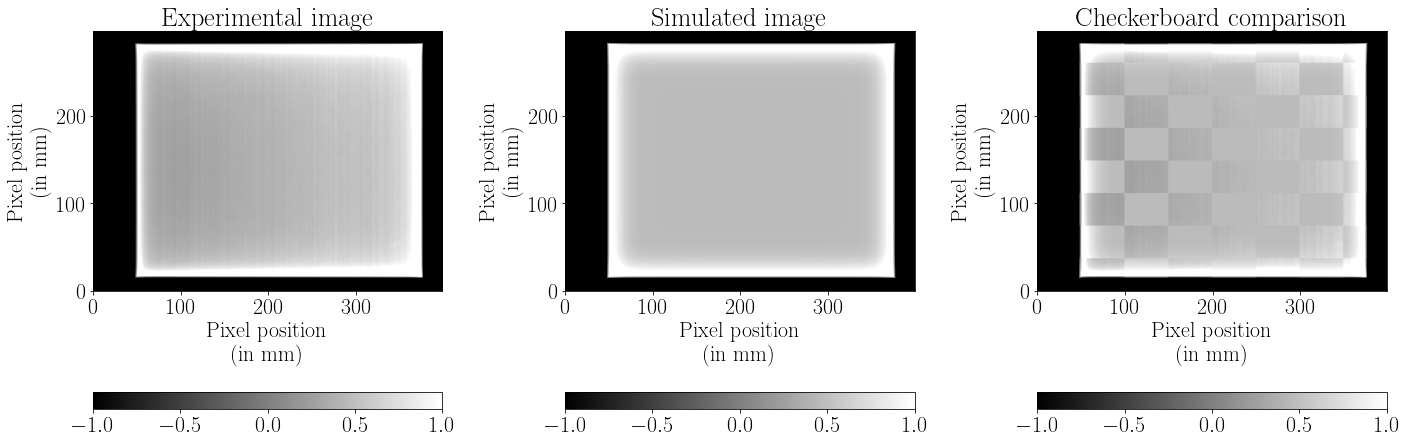

In [55]:
plt.figure(figsize= (20,10))
compareImages(roi_real_image, x_ray_image)
plt.savefig('plots/PMMA_block_compare_images2.pdf')
plt.savefig('plots/PMMA_block_compare_images2.png')

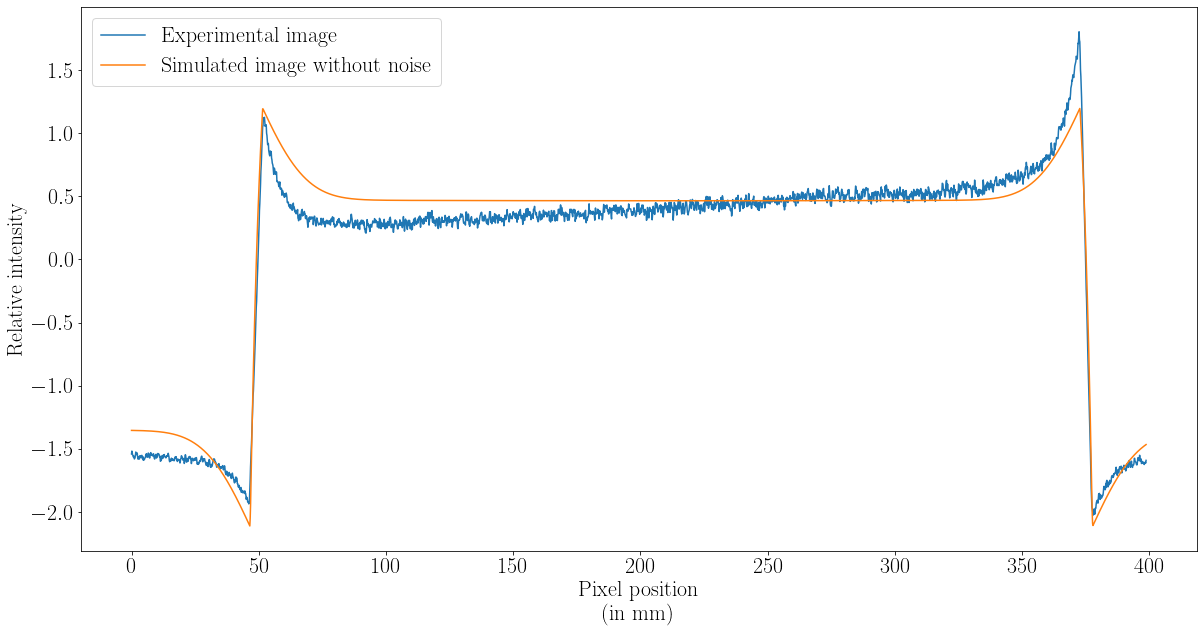

In [56]:
plt.figure(figsize= (20,10))
drawHorizontalProfiles(roi_real_image, x_ray_image)
plt.legend()
plt.savefig('plots/PMMA_block_compare_horizontal_profile2.pdf')
plt.savefig('plots/PMMA_block_compare_horizontal_profile2.png')

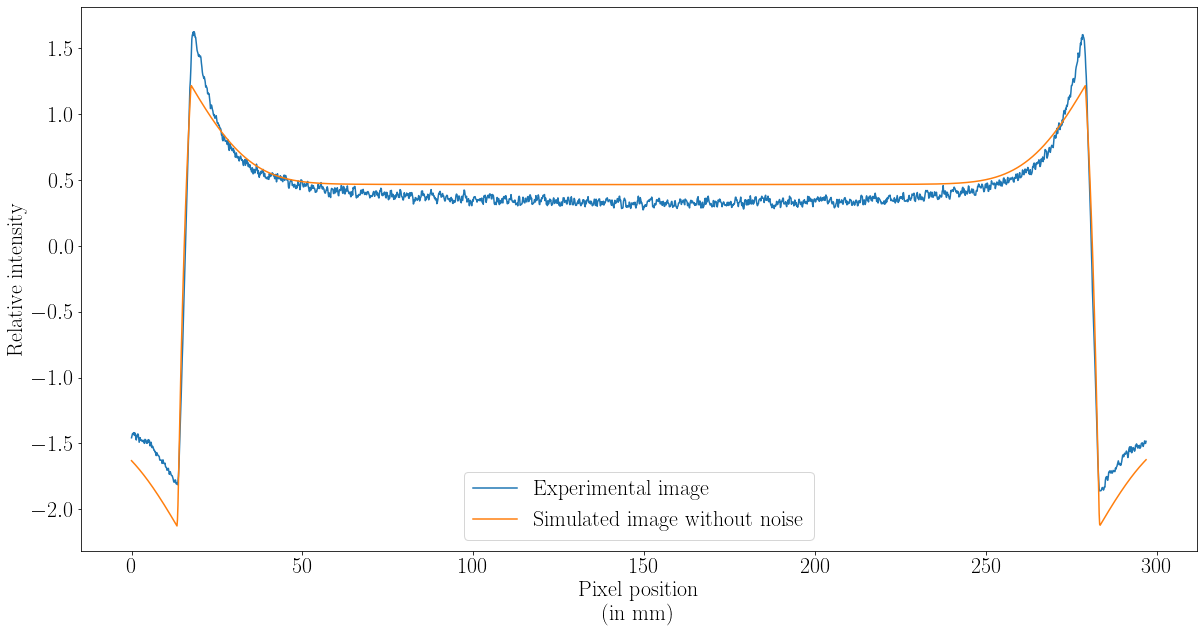

In [57]:
plt.figure(figsize= (20,10))
drawVerticalProfiles(roi_real_image, x_ray_image)
plt.legend()
plt.savefig('plots/PMMA_block_compare_vertical_profile2.pdf')
plt.savefig('plots/PMMA_block_compare_vertical_profile2.png')

In [58]:
print(sigma, alpha)


109.38794225431454 1.5025124231700422


In [59]:
print(shift, scale)

2.841346427259126 1.606676333533941


# Poisson noise

gVirtualXRay exploits the Beer-Lambert law. It does not take into account photon noise. We can, however, estimate the amount of noise in the real X-ray radiograph and replicate it. First we need to build a model of the Poisson noise:

In [60]:
def applyNoise(img, bias, gain, scale):
    
    # Poisson noise
    temp_xray_image = (img + (bias + 1)) * gain
    temp = np.random.poisson(temp_xray_image).astype(np.single)
    temp /= gain
    temp -= bias + 1

    # Noise map
    noise_map = img - temp
    noise_map *= scale;
    noisy_image = img + noise_map
    
    return noisy_image, noise_map

We compute the amplitude of the pixel values in an homogeneous region of interest (ROI) extracted from the ground truth.

In [61]:
centre = [int(roi_real_image.shape[0]/2), int(roi_real_image.shape[1]/2)]
quarter_size = [int(50), int(50)]

reference_noise_ROI = copy.deepcopy(roi_real_image)[centre[0]-quarter_size[0]:centre[0]+quarter_size[0], centre[1]-quarter_size[1]:centre[1]+quarter_size[1]]
test_noise_ROI = copy.deepcopy(x_ray_image)[centre[0]-quarter_size[0]:centre[0]+quarter_size[0], centre[1]-quarter_size[1]:centre[1]+quarter_size[1]]

<Figure size 1440x720 with 0 Axes>

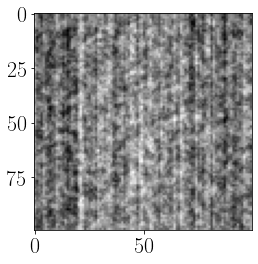

<Figure size 1440x720 with 0 Axes>

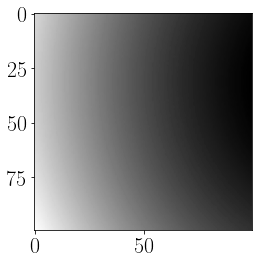

In [62]:
plt.figure(figsize= (20,10))
plt.figure()
plt.imshow(reference_noise_ROI, cmap="gray")
plt.savefig('plots/PMMA_block_ROI_noise_groundtruth.pdf')
plt.savefig('plots/PMMA_block_ROI_noise_groundtruth.png')

plt.figure(figsize= (20,10))
plt.figure()
plt.imshow(test_noise_ROI, cmap="gray")
plt.savefig('plots/PMMA_block_ROI_noise_simulation.pdf')
plt.savefig('plots/PMMA_block_ROI_noise_simulation.png')

In [63]:
min_noise_value = np.min(reference_noise_ROI)
max_noise_value = np.max(reference_noise_ROI)
mean_noise_value = np.mean(reference_noise_ROI)
stddev_noise_value = np.std(reference_noise_ROI)
roi_noise_range = max_noise_value - min_noise_value

print("min_noise_value", min_noise_value)
print("max_noise_value", max_noise_value)
print("mean_noise_value", mean_noise_value)
print("stddev_noise_value", stddev_noise_value)
print("roi_noise_range", roi_noise_range)

min_noise_value 0.29855907402694953
max_noise_value 0.4805347794077794
mean_noise_value 0.388566982215153
stddev_noise_value 0.028201756906621037
roi_noise_range 0.18197570538082986


In [64]:
def fitnessFunctionNoise(x):
    global roi_stddev
    global x_ray_image_response
    
    bias = x[0]
    gain = x[1]
    scale = x[2]
    
    # Extract a ROI from the test image where no object is
    test_noise_ROI = x_ray_image   #copy.deepcopy(standardisation(x_ray_image)[1000:2000,1000:2000])
    test_noise_ROI = copy.deepcopy(x_ray_image)[centre[0]-quarter_size[0]:centre[0]+quarter_size[0], centre[1]-quarter_size[1]:centre[1]+quarter_size[1]]
    
    # Apply the noise model
    noisy_image, noise_map = applyNoise(test_noise_ROI, bias, gain, scale)
        
    # Compute the amplitude of the noise
    noise_range = noise_map.max() - noise_map.min()

    # Square difference
    diff = roi_noise_range - noise_range

    objective = diff * diff

    return objective

We minimise the objective value using a global optimisation algorithm

In [65]:
# Initialise the values
test_noise_ROI = x_ray_image  #copy.deepcopy(x_ray_image[1000:2000,1000:2000])
bias = -x_ray_image.min();
gain = 1.0;
scale = 1;

x0 = [bias, gain, scale];

bounds = [
    [-x_ray_image.min(),   0.0001, -10.0],
    [ 15.0, 15.0, 10.0]
];

opts = cma.CMAOptions()
opts.set('tolfun', 1e-10);
opts['tolx'] = 1e-10;
opts['bounds'] = bounds;
opts['CMA_stds'] = [0.25, 0.25, 0.25];

es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
es.optimize(fitnessFunctionNoise);

bias = es.result.xbest[0];
gain = es.result.xbest[1];
scale = es.result.xbest[2];

# Release memory
del es;

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=97665, Thu Nov  4 10:17:16 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 1.272426198676554e+02 1.0e+00 2.27e-01  5e-02  6e-02 0:00.1
    2     14 1.261294270186724e+02 1.3e+00 2.35e-01  5e-02  6e-02 0:00.1
    3     21 1.069653642763724e+02 1.6e+00 2.68e-01  5e-02  8e-02 0:00.2
   65    455 5.260283400143146e-08 1.0e+01 3.56e-02  3e-04  2e-03 0:03.2
  100    700 4.428970075285511e-07 2.1e+01 3.76e-03  4e-06  9e-05 0:04.9
  200   1400 7.074196000776366e-11 4.6e+02 2.01e-02  2e-06  3e-04 0:09.8
  300   2100 3.260714153694455e-12 1.3e+03 1.55e-03  1e-08  2e-06 0:14.8
  400   2800 1.997291484225797e-13 5.3e+04 1.24e-03  5e-09  6e-07 0:19.8
  500   3500 2.739431585539052e-13 8.2e+05 1.22e-03  4e-09  5e-07 0:24.7
  511   3577 9.582965473654431e-14 9.2e+05 3.67e-04  7e-10  9e-08 0:25.2


In [66]:
print(bias, gain, scale)
x_ray_image_noise, noise_map = applyNoise(x_ray_image, bias, gain, scale)

min_noise_value = np.min(reference_noise_ROI)
max_noise_value = np.max(reference_noise_ROI)
mean_noise_value = np.mean(reference_noise_ROI)
stddev_noise_value = np.std(reference_noise_ROI)

print("min_noise_value", min_noise_value)
print("max_noise_value", max_noise_value)
print("mean_noise_value", mean_noise_value)
print("stddev_noise_value", stddev_noise_value)
print("range", max_noise_value - min_noise_value)

min_noise_value = np.min(noise_map)
max_noise_value = np.max(noise_map)
mean_noise_value = np.mean(noise_map)
stddev_noise_value = np.std(noise_map)

print("min_noise_value", min_noise_value)
print("max_noise_value", max_noise_value)
print("mean_noise_value", mean_noise_value)
print("stddev_noise_value", stddev_noise_value)
print("range", max_noise_value - min_noise_value)

2.533580064779028 1.6704285605292781 -0.016887460933204018
min_noise_value 0.29855907402694953
max_noise_value 0.4805347794077794
mean_noise_value 0.388566982215153
stddev_noise_value 0.028201756906621037
range 0.18197570538082986
min_noise_value -0.08313377989215734
max_noise_value 0.18753490156407598
mean_noise_value 1.1957394772457919e-05
stddev_noise_value 0.02458124423913424
range 0.27066868145623335


Plot the images

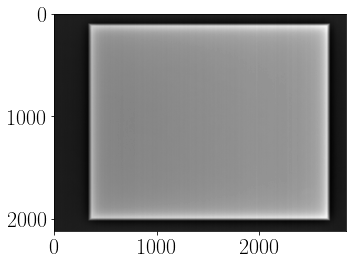

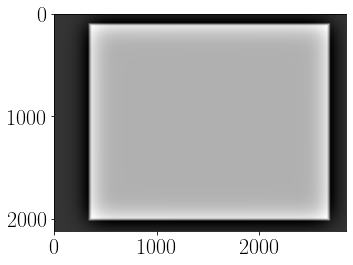

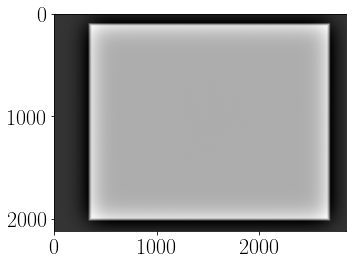

In [67]:
plt.figure(figsize= (20,10))
plt.imshow(roi_real_image, cmap="gray")

plt.figure(figsize= (20,10))
plt.imshow(x_ray_image, cmap="gray")

plt.figure(figsize= (20,10))
plt.imshow(x_ray_image_noise, cmap="gray")
plt.savefig('plots/PMMA_block_simulated_image_with_noise.pdf')
plt.savefig('plots/PMMA_block_simulated_image_with_noise.png')

Plot the profiles

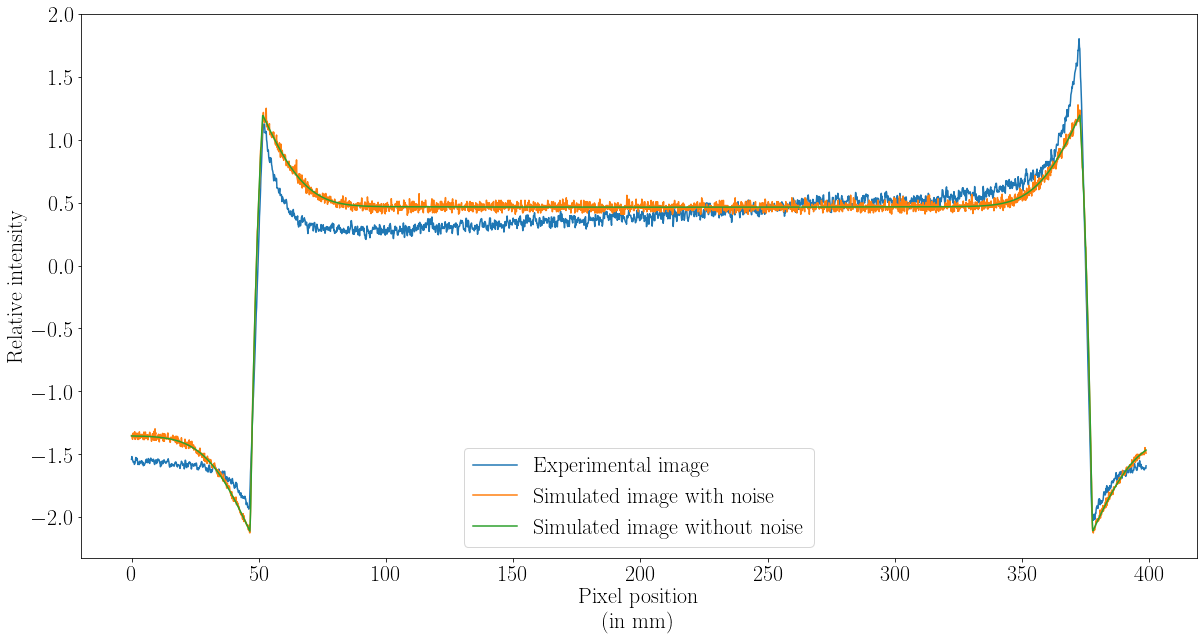

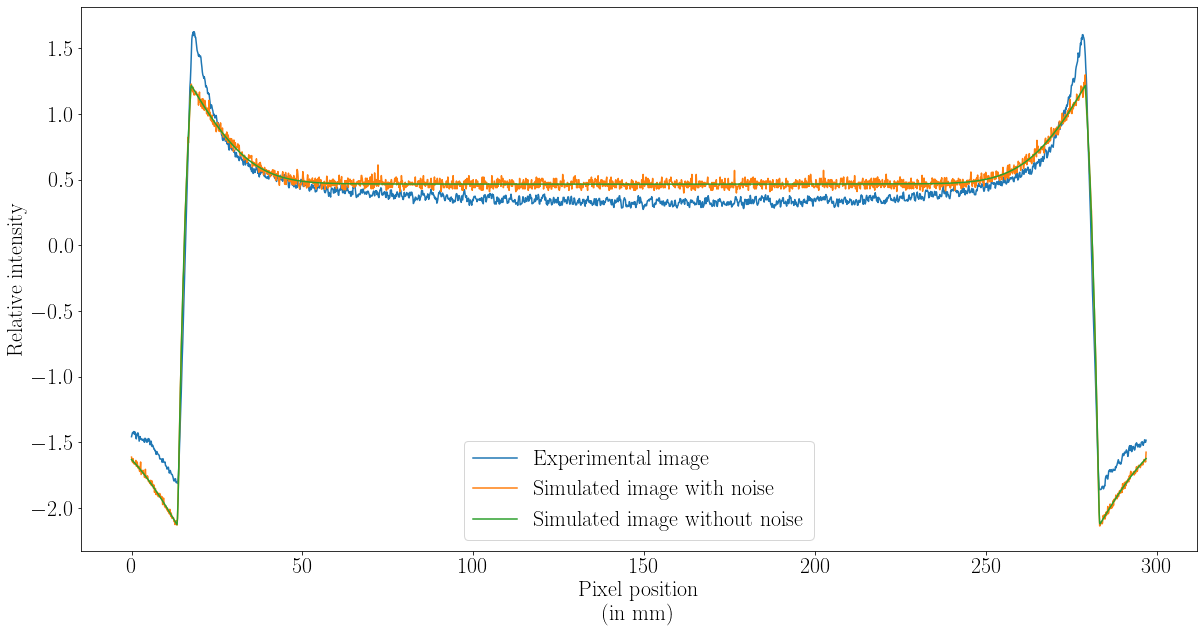

In [68]:
plt.figure(figsize= (20,10))
drawHorizontalProfiles(roi_real_image, x_ray_image, x_ray_image_noise)
plt.legend()
plt.savefig('plots/PMMA_block_compare_horizontal_profile3.pdf')
plt.savefig('plots/PMMA_block_compare_horizontal_profile3.png')

plt.figure(figsize= (20,10))
drawVerticalProfiles(roi_real_image, x_ray_image, x_ray_image_noise)
plt.legend()
plt.savefig('plots/PMMA_block_compare_horizontal_profile3.pdf')
plt.savefig('plots/PMMA_block_compare_horizontal_profile3.png')

Quantify the similarities and differences

In [69]:
MAPE = mape(roi_real_image, x_ray_image)
ZNCC = np.mean((roi_real_image - roi_real_image.mean()) / roi_real_image.std() * (x_ray_image - x_ray_image.mean()) / x_ray_image.std())
SSIM = ssim(roi_real_image, x_ray_image, data_range=roi_real_image.max() - roi_real_image.min())

print("MAPE without noise:", "{0:0.2f}".format(100 * MAPE) + "%")
print("ZNCC without noise", "{0:0.2f}".format(100 * ZNCC) + "%")
print("SSIM without noise:", "{0:0.2f}".format(SSIM))
      
MAPE = mape(roi_real_image, x_ray_image_noise)
ZNCC = np.mean((roi_real_image - roi_real_image.mean()) / roi_real_image.std() * (x_ray_image_noise - x_ray_image_noise.mean()) / x_ray_image_noise.std())
SSIM = ssim(roi_real_image, x_ray_image_noise, data_range=roi_real_image.max() - roi_real_image.min())

print("MAPE with noise:", "{0:0.2f}".format(100 * MAPE) + "%")
print("ZNCC with noise", "{0:0.2f}".format(100 * ZNCC) + "%")
print("SSIM with noise:", "{0:0.2f}".format(SSIM))


MAPE without noise: 27.06%
ZNCC without noise 98.55%
SSIM without noise: 0.93
MAPE with noise: 27.33%
ZNCC with noise 98.52%
SSIM with noise: 0.90
